# Modelo de Simulación de Formación de Opinion

In [67]:
# Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [113]:
# Creamos una clase para la simulación de la formación de opiniones
class OpinionFormationSimulation:
    # Inicializamos la simulación con los parámetros necesarios
    def __init__(self, L, N, m, mu, P, P_tol="1.0", mode="equal", tol_range=(0, 1)):
        self.L = L  # Tamaño del arreglo LxL
        self.N = N  # Número de iteraciones
        self.m = m  # Probabilidad de interacción con propaganda
        self.mu = mu  # Parámetro de interacción
        self.P = P  # Valor de la propaganda
        self.P_tol = P_tol # Tolerancia (efectividad) de la propaganda
        self.mode = mode # Modo de interacción
        self.tol_range = tol_range  # Rango de tolerancia
        
        # Inicializar arreglos
        # self.opinions = np.random.random((L, L)) # Inicializar opiniones aleatorias en [0, 1]
        self.opinions = np.full((L, L), 0.5) # Inicializar opiniones en 0.5
        self.tolerances = np.random.uniform(*tol_range, (L, L)) # Inicializar tolerancias aleatorias en tol_range
        
        # Para guardar la evolución del sistema
        self.opinion_history = [self.opinions.copy()]
    
    # Función para la interacción entre dos opiniones
    def interact(self, opinion, other_opinion, tolerance, other_tolerance, mode = 'equal'):
        # Si las opiniones son similares (bajo tolerencia), se cambia la opinión
        if abs(opinion - other_opinion) < tolerance:
            if mode == 'equal':
                return opinion + self.mu * (other_opinion - opinion)
            elif mode == 'propor':
                return opinion + np.abs(tolerance - other_tolerance)/(tolerance + other_tolerance) * (other_opinion - opinion)
        return opinion
    
    # Función para realizar un paso de la simulación
    def step(self):
        new_opinions = self.opinions.copy() # Copiar opiniones actuales
        # Iterar sobre cada celda
        for i in range(self.L): 
            for j in range(self.L):
                # Segun la probabilidad m se decide si interactuar con propaganda o vecinos
                if np.random.random() < self.m:
                    # Interacción con propaganda
                    new_opinions[i, j] = self.interact(self.opinions[i, j], self.P, self.tolerances[i, j], self.P_tol, mode=self.mode)
                else:
                    # Interacción con vecinos
                    neighbors = [
                        (i-1, j), (i+1, j),
                        (i, j-1), (i, j+1)
                    ]
                    # Iterar sobre los vecinos
                    for ni, nj in neighbors:
                        # Verificar que el vecino esté dentro del arreglo
                        if 0 <= ni < self.L and 0 <= nj < self.L:
                            new_opinions[i, j] = self.interact(new_opinions[i, j], self.opinions[ni, nj], self.tolerances[i, j], self.tolerances[ni, nj], mode=self.mode)
        
        # Guardar las nuevas opiniones
        self.opinions = new_opinions
        # Guardar la evolución del sistema
        self.opinion_history.append(self.opinions.copy())
    
    # Función para correr la simulación
    def run_simulation(self):
        for _ in range(self.N):
            self.step()
    
    # Función para graficar la evolución del sistema
    def plot_evolution(self):
        # Crear 4 subplots
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten() 
        
        # Titulo del gráfico
        fig.suptitle("Evolución de opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}")

        # Pasos a graficar (0, N/3, 2N/3, N)
        steps_to_plot = [0, self.N // 3, 2 * self.N // 3, -1]
        
        # Iterar sobre los pasos a graficar
        for i, step in enumerate(steps_to_plot):
            ax = axes[i] # Obtener el subplot actual
            im = ax.imshow(self.opinion_history[step], cmap='bwr', vmin=0, vmax=1) # Graficar opiniones
            ax.set_title(f"Paso {step if step != -1 else self.N}") # Título del subplot
            fig.colorbar(im, ax=ax) # Agregar barra de color
        
        plt.tight_layout()
        plt.show()
        return fig
    
    # Función para graficar el histograma de las opiniones finales
    def plot_histogram(self):
        plt.figure(figsize=(10, 6))
        plt.hist(self.opinions.flatten(), bins=40, range=(0, 1), edgecolor='black') # Graficar histograma
        plt.title("Distribución final de opiniones")
        plt.xlabel("Opinión")
        plt.ylabel("Frecuencia")
        plt.show()
        return plt.gcf()
    
    # Función para graficar la evolución de la opinión de un punto
    def plot_point_evolution(self, i, j):
        # Obtener la evolución de la opinión del punto (i, j)
        point_evolution = [history[i, j] for history in self.opinion_history]
        # Graficar la evolución
        plt.figure(figsize=(10, 6))
        plt.plot(point_evolution)
        plt.title(f"Evolución de la opinión en ({i}, {j})")
        plt.xlabel("Paso")
        plt.ylabel("Opinión")
        plt.show()
        return plt.gcf()
    
    # Función para animar la evolución del sistema
    def create_animation(self, save_path, interval=50, fps=10):
        """
        Crea una animación de la evolución de las opiniones y la guarda en la ruta especificada.
        
        :param save_path: Ruta donde se guardará el archivo de animación (debe terminar en .mp4)
        :param interval: Intervalo entre frames en milisegundos
        :param fps: Frames por segundo para el video guardado
        """
        fig, ax = plt.subplots()
        
        # Inicializar la imagen
        im = ax.imshow(self.opinion_history[0], cmap='bwr', animated=True, vmin=0, vmax=1)

        # Agregar el contador de frames
        ax.text(0.02, 0.02, "Frame: 0", transform=ax.transAxes)
        
        # Función de actualización para la animación
        def update(frame):
            im.set_array(self.opinion_history[frame])
            ax.texts[0].set_text(f"Frame: {frame}")
            return [im]
        
        # Crear la animación
        anim = animation.FuncAnimation(fig, update, frames=len(self.opinion_history), 
                                       interval=interval, blit=True)
        
        # Agregar una barra de color
        plt.colorbar(im)
        
        # Configurar el título
        # ax.set_title("Evolución de las opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}")
        fig.suptitle("Evolución de opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}")

        # Guardar la animación
        anim.save(save_path, fps=fps)
        
        plt.close(fig)
        print(f"Animación guardada en {save_path}")

In [103]:
# Ejemplo de uso
L = 100  # Tamaño del arreglo
N = 100  # Número de iteraciones
m = 0.2  # Probabilidad de interacción con propaganda
mu = 0.5  # Parámetro de interacción
P = 1.0  # Valor de la propaganda
P_tol = 1.0  # Tolerancia (efectividad) de la propaganda
mode = 'equal'  # Modo de interacción

simulation = OpinionFormationSimulation(L, N, m, mu, P, P_tol, mode)
simulation.run_simulation()

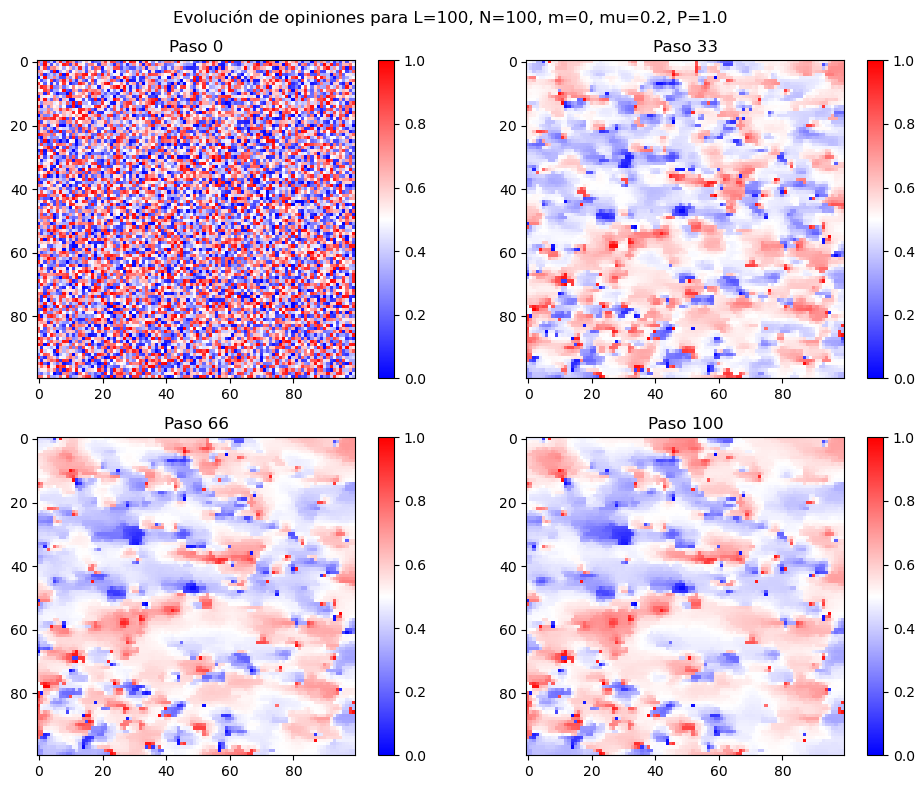

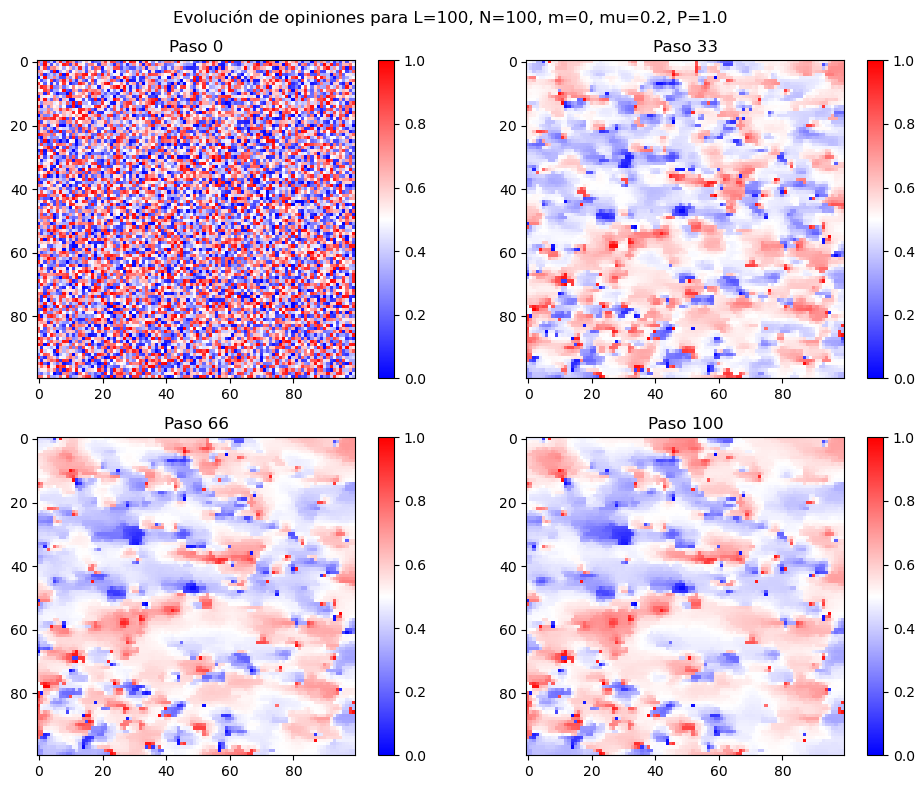

In [105]:
# simulation.plot_evolution().savefig("../results/evolution/opinion_evolution"+ f"m00"+".png")
simulation.plot_evolution()

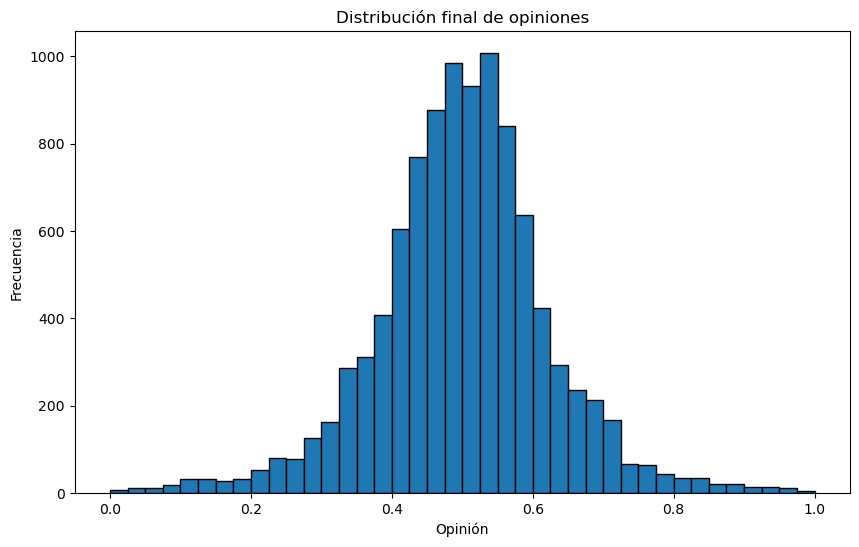

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [106]:
# simulation.plot_histogram().savefig("../results/final_hist/opinion_histogram"+ f"m00"+".png")
simulation.plot_histogram()

In [112]:
(simulation.opinions>1).sum()

0

In [107]:
simulation.create_animation("../results/animations/opinion_evolution"+ f"m00prop"+".gif", interval=50, fps=20)

MovieWriter ffmpeg unavailable; using Pillow instead.


Animación guardada en ../results/animations/opinion_evolutionm00prop.gif
